In [1]:
!pip install osmnx==1.1.2 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.9/95.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.1/541.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 73.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.1.0 requires shapely>=2.0.0, but you have shapely 1.8.5.post1 which is incompatible.


In [2]:
import itertools
import math
from math import radians, sin, cos, asin, sqrt
import pandas as pd
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D


# 🌐 Utilidades


In [3]:
def haversine_m(lat1, lon1, lat2, lon2):
    """Distancia geodésica en metros entre dos (lat, lon)."""
    R = 6_371_000
    dlat, dlon = radians(lat2-lat1), radians(lon2-lon1)
    a = (sin(dlat/2)**2 +
         cos(radians(lat1))*cos(radians(lat2))*sin(dlon/2)**2)
    return 2*R*asin(sqrt(a))

def astar_len(G, u, v):
    """Longitud (m) del camino A* más corto entre nodos u‑v."""
    # NetworkX ≥2.6 tiene astar_path_length
    try:
        return nx.astar_path_length(G, u, v, weight="length")
    except AttributeError:              # retro‑compatibilidad
        path = nx.astar_path(G, u, v, weight="length")
        return sum(
            min(G.get_edge_data(a, b).values(),
                key=lambda d: d["length"])["length"]
            for a, b in zip(path[:-1], path[1:])
        )


# 📍 Parámetros de entrada


In [4]:
# Origen / destino
A = (-12.15457, -76.98188)  # almacén

# Entregas
waypoints = [
    (-12.14810, -76.98500),  # P1
    (-12.14230, -76.97840),  # P2
    (-12.13580, -76.98970),  # P3
    (-12.13025, -76.99088)   # P4
]

# El motorizado termina en la última parada (no regresa)
return_to_origin = False

# Velocidad media para estimar tiempo
speed_kmh = 30


# 🌐 Descarga de la red vial


In [5]:
# BBOX que abarque todos los puntos + pequeño buffer
lats = [A[0]] + [lat for lat, _ in waypoints]
lons = [A[1]] + [lon for _, lon in waypoints]
buffer = 0.003  # ≈300 m

north, south = max(lats)+buffer, min(lats)-buffer
east,  west  = max(lons)+buffer, min(lons)-buffer

G = ox.graph_from_bbox(north, south, east, west,
                       network_type="drive", simplify=True)
print(f"⛓️  Red descargada: {len(G.nodes):,} nodos – {len(G.edges):,} aristas")


⛓️  Red descargada: 1,146 nodos – 2,683 aristas


# 🔄 Conversión coordenadas → nodos OSM


In [7]:
A_node  = ox.distance.nearest_nodes(G, A[1], A[0])
wp_nodes = [ox.distance.nearest_nodes(G, lon, lat) for lat, lon in waypoints]

labels = ["Inicio"] + [f"Parada {i+1}" for i in range(len(wp_nodes))]
if return_to_origin:
    labels.append("Fin")
else:
    labels[-1] = "Fin"


# 🚚 TSP < 10 paradas (fuerza bruta) para 4 entregas


In [8]:
best_order, best_len = None, math.inf
for perm in itertools.permutations(wp_nodes):          # 4! = 24
    candidate = (A_node, *perm, A_node) if return_to_origin else (A_node, *perm)
    L = sum(astar_len(G, u, v) for u, v in zip(candidate[:-1], candidate[1:]))
    if L < best_len:
        best_len, best_order = L, candidate

print("🗺️  Secuencia óptima:", best_order)


🗺️  Secuencia óptima: (5396224693, 10827539064, 1414370607, 1414370289, 440918192)


# 📊 Métricas por tramo y totales


In [9]:
segment_metrics = []
for i, (u, v) in enumerate(zip(best_order[:-1], best_order[1:]), start=1):
    astar_m = astar_len(G, u, v)
    geod_m  = haversine_m(G.nodes[u]['y'], G.nodes[u]['x'],
                          G.nodes[v]['y'], G.nodes[v]['x'])
    tmin    = astar_m / (speed_kmh*1000/60)
    segment_metrics.append(dict(
        Tramo=i, De=labels[i-1], A=labels[i],
        Dist_Astar_m=astar_m, Dist_Geod_m=geod_m,
        Tiempo_min=tmin, Eficiencia=geod_m/astar_m
    ))

df_segments = pd.DataFrame(segment_metrics)
display(df_segments.style.format({
    "Dist_Astar_m":"{:.0f}",
    "Dist_Geod_m":"{:.0f}",
    "Tiempo_min":"{:.1f}",
    "Eficiencia":"{:.3f}"
}))


,Tramo,De,A,Dist_Astar_m,Dist_Geod_m,Tiempo_min,Eficiencia
0,1,Inicio,Parada 1,2405,1409,4.8,0.586
1,2,Parada 1,Parada 2,2197,957,4.4,0.436
2,3,Parada 2,Parada 3,1757,1432,3.5,0.815
3,4,Parada 3,Fin,922,637,1.8,0.691


In [10]:
total_length_m = sum(m["Dist_Astar_m"] for m in segment_metrics)
geod_total     = haversine_m(G.nodes[best_order[0]]['y'], G.nodes[best_order[0]]['x'],
                             G.nodes[best_order[-1]]['y'], G.nodes[best_order[-1]]['x'])
time_total_min = total_length_m / (speed_kmh*1000/60)

print(f"Total A*:     {total_length_m:,.0f} m")
print(f"Geodésica:    {geod_total:,.0f} m")
print(f"Tiempo (≈):   {time_total_min:.1f} min")
print(f"Eficiencia:   {geod_total/total_length_m:.3f}")


Total A*:     7,281 m
Geodésica:    2,840 m
Tiempo (≈):   14.6 min
Eficiencia:   0.390


# 🖼️ Visualización – colores paralelos por tramo


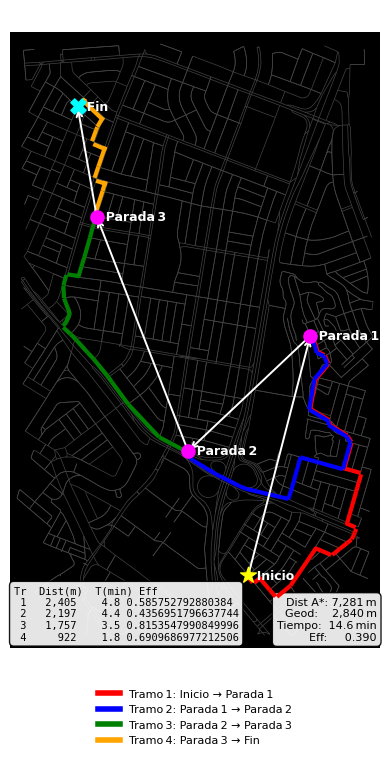

In [11]:
# ----- utilidades de trazado ---------------------------------------------
def offset_line(x0, y0, x1, y1, delta):
    """Devuelve segmento desplazado 'delta' en dirección normal."""
    dx, dy   = x1 - x0, y1 - y0
    length   = math.hypot(dx, dy) or 1
    nx, ny   = -dy/length, dx/length
    return [(x0 + delta*nx, y0 + delta*ny),
            (x1 + delta*nx, y1 + delta*ny)]

colors = ['red','blue','green','orange','purple','cyan','yellow','deeppink']
offset_step = 0.00006  # ≈6 m en Lima
handles = []

fig, ax = ox.plot_graph(G, node_size=0, edge_color='#444444',
                        edge_linewidth=0.5, bgcolor='black',
                        show=False, close=False)

for i, (u, v) in enumerate(zip(best_order[:-1], best_order[1:]), start=1):
    seg_nodes = nx.astar_path(G, u, v, weight="length")
    color = colors[(i-1) % len(colors)]
    delta = (i - (len(best_order)-1)/2) * offset_step
    lines = [offset_line(G.nodes[a]['x'], G.nodes[a]['y'],
                         G.nodes[b]['x'], G.nodes[b]['y'], delta)
             for a, b in zip(seg_nodes[:-1], seg_nodes[1:])]
    ax.add_collection(LineCollection(lines, colors=color, linewidths=3, zorder=4))
    handles.append(Line2D([0],[0], color=color, lw=4,
                          label=f'Tramo {i}: {labels[i-1]} → {labels[i]}'))

# Nodos y etiquetas
for idx, node in enumerate(best_order):
    x, y = G.nodes[node]['x'], G.nodes[node]['y']
    style = dict(c='magenta', s=90, marker='o')
    if idx == 0:                      style = dict(c='yellow', s=140, marker='*')
    if idx == len(best_order)-1:      style = dict(c='cyan',   s=120, marker='X')
    ax.scatter(x, y, zorder=6, **style)
    ax.text(x, y, f"  {labels[idx]}", fontsize=9, weight='bold',
            va='center', ha='left', color='white', zorder=7)

# Flechas (sin offset)
for u, v in zip(best_order[:-1], best_order[1:]):
    ax.annotate("", xy=(G.nodes[v]['x'], G.nodes[v]['y']),
                xytext=(G.nodes[u]['x'], G.nodes[u]['y']),
                arrowprops=dict(arrowstyle="->", lw=1.4, color='white'),
                zorder=5)

# Leyenda colores
ax.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, -0.05),
          frameon=False, fontsize=8)

# KPIs totales
kpi = (f"Dist A*: {total_length_m:,.0f} m\n"
       f"Geod:    {geod_total:,.0f} m\n"
       f"Tiempo:  {time_total_min:.1f} min\n"
       f"Eff:     {geod_total/total_length_m:.3f}")
ax.text(0.99, 0.01, kpi, transform=ax.transAxes, ha='right', va='bottom',
        bbox=dict(boxstyle="round,pad=0.4", facecolor='white', alpha=0.9),
        fontsize=8)

# KPIs por tramo (monospace)
txt = ["Tr  Dist(m)  T(min) Eff"]
txt += [f"{m['Tramo']:>2} {m['Dist_Astar_m']:>7,.0f}"
        f" {m['Tiempo_min']:>6.1f} {m['Eficiencia']:>5}"
        for m in segment_metrics]
ax.text(0.01, 0.01, "\n".join(txt), transform=ax.transAxes,
        ha='left', va='bottom', family='monospace',
        bbox=dict(boxstyle="round,pad=0.4", facecolor='white', alpha=0.9),
        fontsize=7.5)

ax.set_title("Ruta óptima con 4 entregas", color='white')
plt.show()
